# **IMPORTADO DE MÓDULOS**

In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
from scipy.optimize import curve_fit
#https://gist.github.com/cpascual/a03d0d49ddd2c87d7e84b9f4ad2df466
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

In [20]:
V55= np.load('/home/josea/Co60_5cm_5cm.npy')
V28= np.load('/home/josea/Co60_2cm_8cm.npy')
V82= np.load('/home/josea/Co60_8cm_2cm.npy')

# **CFD**

In [21]:
#------------------------------------------------------------------------------------------------------------
def constant_fraction_discrimination(vector, fraction = 0.9, shift = 30):
    corrected_signal = np.zeros_like(vector)
    for i in range(vector.shape[0]):
      inverted_signal = np.roll(-vector[i,:],shift)
      inverted_signal[0:shift] = 0.
      fraction_signal = fraction*vector[i,:]
      corrected_signal[i,:] = inverted_signal + fraction_signal
      plt.plot(corrected_signal[i,:])
    return corrected_signal

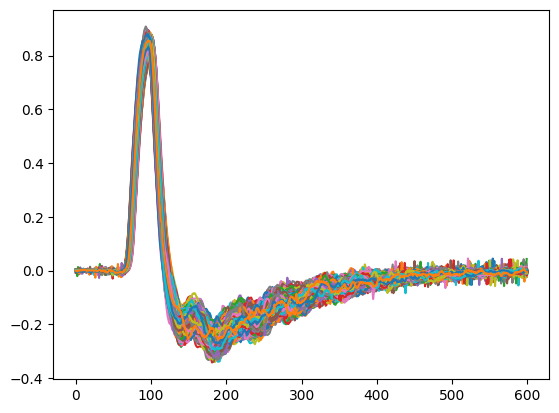

In [22]:
V28_dec0 = constant_fraction_discrimination(V28[:,:,0])
V55_dec0 = constant_fraction_discrimination(V55[:,:,0])
V82_dec0 = constant_fraction_discrimination(V82[:,:,0])

V28_dec1 = constant_fraction_discrimination(V28[:,:,1])
V55_dec1 = constant_fraction_discrimination(V55[:,:,1])
V82_dec1 = constant_fraction_discrimination(V82[:,:,1])

V28_fraction = np.concatenate((V28_dec0[:,:,np.newaxis],V28_dec1[:,:,np.newaxis]), axis = 2)
V55_fraction = np.concatenate((V55_dec0[:,:,np.newaxis],V55_dec1[:,:,np.newaxis]), axis = 2)
V82_fraction = np.concatenate((V82_dec0[:,:,np.newaxis],V82_dec1[:,:,np.newaxis]), axis = 2)

In [23]:
def calculate_slope_y_intercept(vector, time_step, threshold = 0.1):
  t = np.arange(vector.shape[0]) * time_step
  index = np.where(vector > threshold)[0][0]
  t1 = t[index]
  t0 = t[index - 1]
  m = (vector[index] - vector[index - 1]) / (t1 - t0)
  b = vector[index-1] - m*t0
  time = (threshold - b) / m
  return time

# **DETECTOR 0**

In [24]:
timestamps_dec0_V82_list = []
timestamps_dec0_V55_list = []
timestamps_dec0_V28_list = []


for i in range(V82_fraction.shape[0]):
  timestamp = calculate_slope_y_intercept(V82_fraction[i,:,0], 0.2, threshold = 0.1)
  timestamps_dec0_V82_list.append(timestamp)

for i in range(V55_fraction.shape[0]):
  timestamp = calculate_slope_y_intercept(V55_fraction[i,:,0], 0.2, threshold = 0.1)
  timestamps_dec0_V55_list.append(timestamp)

for i in range(V28_fraction.shape[0]):
  timestamp = calculate_slope_y_intercept(V28_fraction[i,:,0], 0.2, threshold = 0.1)
  timestamps_dec0_V28_list.append(timestamp)

timestamps_dec0_V82 = np.array(timestamps_dec0_V82_list)
timestamps_dec0_V55 = np.array(timestamps_dec0_V55_list)
timestamps_dec0_V28 = np.array(timestamps_dec0_V28_list)

# **DETECTOR 1**

In [25]:
timestamps_dec1_V82_list = []
timestamps_dec1_V55_list = []
timestamps_dec1_V28_list = []


for i in range(V82_fraction.shape[0]):
  timestamp = calculate_slope_y_intercept(V82_fraction[i,:,1], 0.2, threshold = 0.1)
  timestamps_dec1_V82_list.append(timestamp)

for i in range(V55_fraction.shape[0]):
  timestamp = calculate_slope_y_intercept(V55_fraction[i,:,1], 0.2, threshold = 0.1)
  timestamps_dec1_V55_list.append(timestamp)

for i in range(V28_fraction.shape[0]):
  timestamp = calculate_slope_y_intercept(V28_fraction[i,:,1], 0.2, threshold = 0.1)
  timestamps_dec1_V28_list.append(timestamp)

timestamps_dec1_V82 = np.array(timestamps_dec1_V82_list)
timestamps_dec1_V55 = np.array(timestamps_dec1_V55_list)
timestamps_dec1_V28 = np.array(timestamps_dec1_V28_list)

# **FULL TOF**


V82: CENTROID(ns) = 0.207  FWHM(ns) = 0.174
V55: CENTROID(ns) = 0.009  FWHM(ns) = 0.156
V28: CENTROID(ns) = -0.219  FWHM(ns) = 0.165


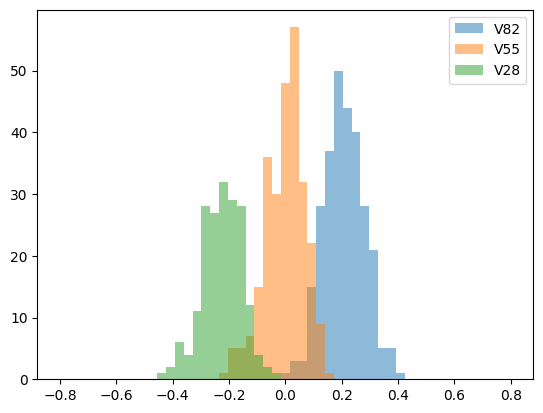

In [26]:
TOFN_V82 = timestamps_dec0_V82 - timestamps_dec1_V82
TOFN_V55 = timestamps_dec0_V55 - timestamps_dec1_V55
TOFN_V28 = timestamps_dec0_V28 - timestamps_dec1_V28
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(TOFN_V82 - np.mean(TOFN_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(TOFN_V55 - np.mean(TOFN_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(TOFN_V28 - np.mean(TOFN_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f" % (x0N_V82, FWHMN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f" % (x0N_V55, FWHMN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f" % (x0N_V28, FWHMN_V28))

In [27]:
Error_V82 = (TOFN_V82 - 0.2)**2
Error_V55 = (TOFN_V55)**2
Error_V28 = (TOFN_V28 + 0.2)**2

Error = np.concatenate((Error_V82, Error_V55, Error_V28))
MSE = np.mean(Error)   
print(MSE)          

0.017469294670679848


# **LOAD RESULTS FROM GENÉTICO**

In [77]:
data_hist_V82 = '/home/josea/ResultGenetico/hist-co-8cm-2cm-gate.txt'
data_hist_V55 = '/home/josea/ResultGenetico/hist-co-5cm-5cm-gate.txt'
data_hist_V28 = '/home/josea/ResultGenetico/hist-co-2cm-8cm-gate.txt'

bins_V82,histog_V82,_ = np.loadtxt(data_hist_V82, dtype = str, unpack = True, skiprows= 4) 
bins_V55,histog_V55,_ = np.loadtxt(data_hist_V55, dtype = str, unpack = True, skiprows= 4)
bins_V28,histog_V28,_ = np.loadtxt(data_hist_V28, dtype = str, unpack = True, skiprows= 4)

histog_V82 = histog_V82.astype(float)
histog_V55 = histog_V55.astype(float)
histog_V28 = histog_V28.astype(float)

bins_V82 = bins_V82.astype(float)
bins_V55 = bins_V55.astype(float)
bins_V28 = bins_V28.astype(float)


(-1.2, 0.0)

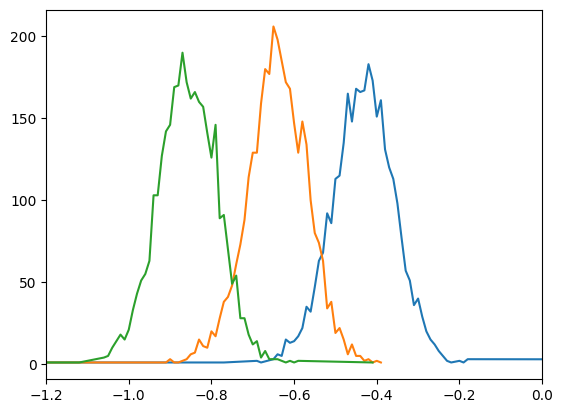

In [146]:
plt.plot(bins_V82, histog_V82)
plt.plot(bins_V55, histog_V55)
plt.plot(bins_V28, histog_V28)
plt.xlim([-1.2,0.0])

In [154]:
new_histog_V82 = []
new_bins_V82 = []

new_histog_V55 = []
new_bins_V55 = []

new_histog_V28 = []
new_bins_V28 = []


for i in range(len(bins_V82)):
    for j in range(int(histog_V82[i])):
        new_histog_V82.append(1)
        new_bins_V82.append(bins_V82[i])
    

for i in range(len(bins_V55)):
    for j in range(int(histog_V55[i])):
        new_histog_V55.append(1)
        new_bins_V55.append(bins_V55[i])


for i in range(len(bins_V28)):
    for j in range(int(histog_V28[i])):
        new_histog_V28.append(1)
        new_bins_V28.append(bins_V28[i])


new_histog_V82 = np.array(new_histog_V82, dtype = 'float64')
new_bins_V82 = np.array(new_bins_V82, dtype = 'float64')

new_histog_V55 = np.array(new_histog_V55, dtype = 'float64')
new_bins_V55 = np.array(new_bins_V55, dtype = 'float64')

new_histog_V28 = np.array(new_histog_V28, dtype = 'float64')
new_bins_V28 = np.array(new_bins_V28, dtype = 'float64')

In [156]:
TOFN_V82 = new_histog_V82*new_bins_V82
TOFN_V55 = new_histog_V55*new_bins_V55
TOFN_V28 = new_histog_V28*new_bins_V28

new_TOFN_V82 = TOFN_V82 - np.mean(TOFN_V55)
new_TOFN_V55 = TOFN_V55 - np.mean(TOFN_V55)
new_TOFN_V28 = TOFN_V28 - np.mean(TOFN_V55)


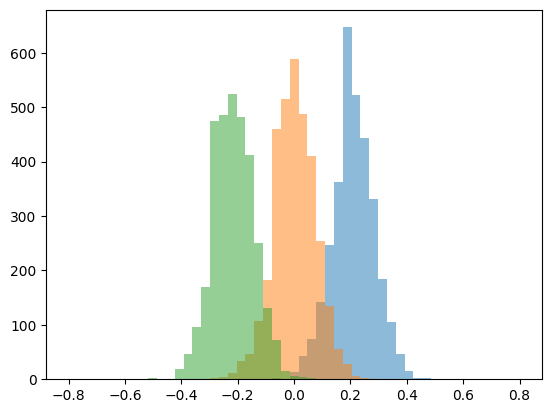

In [161]:
nbins = 51
plt.hist(new_TOFN_V82, bins = nbins, range = [-0.8,0.8], alpha=0.5);
plt.hist(new_TOFN_V55, bins = nbins, range = [-0.8,0.8], alpha=0.5);
plt.hist(new_TOFN_V28, bins = nbins, range = [-0.8,0.8], alpha=0.5);

In [163]:
Error_V82 = (new_TOFN_V82 - 0.2)**2
Error_V55 = (new_TOFN_V55)**2
Error_V28 = (new_TOFN_V28 + 0.2)**2

Error = np.concatenate((Error_V82, Error_V55, Error_V28))
MSE = np.mean(Error)   
print(MSE)                                                                                                               

0.05111344429241426
